In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict as ordict
from tqdm import tqdm
from PIL import Image

import openfermion as of
from openfermion.utils import commutator
from openfermion.linalg import get_sparse_operator, get_ground_state
from openfermion.transforms import get_quadratic_hamiltonian
from openfermion.circuits import gaussian_state_preparation_circuit, jw_get_gaussian_state, \
                                 slater_determinant_preparation_circuit


from mindspore import Tensor
from mindquantum import *
import mindspore as ms
import mindspore.nn as nn
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
abs_path = os.path.abspath('')

/Users/hbar/opt/anaconda3/envs/mindquantum/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/Users/hbar/opt/anaconda3/envs/mindquantum/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR


In [2]:
swap_even_odd_index = [(2*k,2*k+1) for k in range(6)]
swap_odd_even_index = [(2*k+1, 2*k+2) for k in [0,1,3,4]]
onsite_index = [(2*i,2*i+1) for i in range(6)]
swap_index = [(2*i,2*i+1) for i in range(6)]

### Given swap gate

In [3]:
def givens_iswap(qubits, theta):

    circuit = Circuit()
    theta = theta
    circuit.append(FSim(-np.pi/4, 0).on([qubits[0],qubits[1]]))
    circuit.append(RZ(theta).on(qubits[0]))
    circuit.append(RZ(-theta).on(qubits[1]))
    circuit += Z.on(qubits[1])
    circuit.append(FSim(-np.pi/4, 0).on([qubits[0],qubits[1]]))
    circuit += Z.on(qubits[1])
    
    return circuit

In [4]:
theta = np.pi/2
G = givens_iswap([0,1], theta)
#print(G.matrix().round(2))

### Quantum gate and inital circuits

In [5]:
def Cphase(phi, qubit):
    circuit = Circuit()
    circuit += PhaseShift(phi).on(qubit[1],qubit[0])
    return circuit

def FSWAP(qubit):
    circuit = Circuit()
    circuit += SWAP([qubit[0],qubit[1]])
    circuit += Z.on(qubit[1],qubit[0])    
    return circuit

def Hopping_Gate(theta, qubit):
    
    circuit = Circuit()
    circuit += FSim(theta, 0).on([qubit[0],qubit[1]])
    return circuit

def median(x):
    x = sorted(x)
    length = len(x)
    mid, rem = divmod(length, 2)    # divmod函数返回商和余数
    if rem:
        return x[:mid], x[mid+1:], x[mid]
    else:
        return x[:mid], x[mid:], (x[mid-1]+x[mid])/2


def inital_circuits(occupied, circuit_description):
    
    circuit = Circuit()
    for i in range(occupied):
        circuit += X.on(i)

    circuit.barrier()

    for i in circuit_description:
        if len(i) == 1:
            q0 = i[0][0]
            q1 = i[0][1]
            theta = i[0][2]
            circuit += givens_iswap([q0, q1], theta)
            circuit.barrier()
        if len(i) != 1:
            for j in i:
                q0 = j[0]
                q1 = j[1]
                theta = j[2]
                circuit += givens_iswap([q0, q1], theta)
                circuit.barrier()
                
    return circuit

In [6]:
def get_expectation_of_hamitonian(circ, ham, pr):

    sim = Simulator('mqvector', circ.n_qubits)
    sim.apply_circuit(circ, pr)
    result = sim.get_expectation(ham)
        
    return result.real

def CD_operator(CD):
    
    CD_term = []
    for cd in CD.split():
        CD_term.append(cd[1])
    k = 0
    out = ordict()
    for cd in CD_term:
        for key, term in cd.terms.items():
            if len(key) == 2:
                if key not in out:
                    out[key] = ordict({f"p{k}": 1})
                    k += 1
    return out

def CD_ansataz(out):
    "Transform a pauli ansatz to parameterized quantum circuit."

    circuit = Circuit()
    circuit += inital_circuits(occupied, circuit_description)
    z = 0
    for k, v in out.items():
        index1 = (k[0][0], k[1][0])
        index2 = (k[1][0], k[0][0])

        pauli_operator = (str(k[0][1]), str(k[1][1]))
        if pauli_operator == ('X','Y'):
            circuit += Rxy(f'{z}').on(index1)
        else:
            circuit += Rxy(f'{z}').on(index2)            
        z+=1 
    
    return circuit

#### Hamitonian variation Ansatze

In [7]:
def Hamitonian_Variational_Ansatze(p):
    
    circuit = Circuit()
    
    occupied = 6
    circuit += inital_circuits(occupied, circuit_description)
    
    for i in range(p):
        # onsite hamitonian
        for qubit_index in onsite_index:
            circuit += Cphase(f"phi{qubit_index*(i+1)}", qubit_index)
        circuit.barrier()

        # SWAP
        for qubit_index in swap_even_odd_index: # SWAP GATE even odd  
            circuit += FSWAP(qubit_index)
        for qubit_index in swap_odd_even_index: # SWAP GATE odd even
            circuit += FSWAP(qubit_index)
        circuit.barrier()

        circuit += Hopping_Gate(theta=f"beta1{i*p}", qubit=[4,5])
        circuit += Hopping_Gate(theta=f"beta2{i*p}", qubit=[6,7])
        circuit += Hopping_Gate(theta=f"beta3{i*p}", qubit=[5,6])
        circuit.barrier()

        # SWAP
        for qubit_index in swap_even_odd_index: # SWAP GATE even odd  
            circuit += FSWAP(qubit_index)
        for qubit_index in swap_odd_even_index: # SWAP GATE odd even
            circuit += FSWAP(qubit_index)
        circuit.barrier()

        circuit += Hopping_Gate(theta=f"beta4{i*p}", qubit=[4,5])
        circuit += Hopping_Gate(theta=f"beta5{i*p}", qubit=[6,7])
        circuit.barrier()

        # SWAP
        for qubit_index in swap_even_odd_index: # SWAP GATE even odd  
            circuit += FSWAP(qubit_index)
        for qubit_index in swap_odd_even_index: # SWAP GATE odd even
            circuit += FSWAP(qubit_index)
        circuit.barrier()

        circuit += Hopping_Gate(theta=f"beta6{i*p}", qubit=[5,6])
        circuit.barrier()

        # SWAP
        for qubit_index in swap_even_odd_index: # SWAP GATE even odd  
            circuit += FSWAP(qubit_index)
        for qubit_index in swap_odd_even_index: # SWAP GATE odd even
            circuit += FSWAP(qubit_index)
        circuit.barrier()

        circuit += Hopping_Gate(theta=f"beta7{i*p}", qubit=[4,5])
        circuit += Hopping_Gate(theta=f"beta8{i*p}", qubit=[6,7])
        circuit += Hopping_Gate(theta=f"beta9{i*p}", qubit=[5,6])
        circuit.barrier()

        # SWAP
        for qubit_index in swap_even_odd_index: # SWAP GATE even odd  
            circuit += FSWAP(qubit_index)
        for qubit_index in swap_odd_even_index: # SWAP GATE odd even
            circuit += FSWAP(qubit_index)
        circuit.barrier()

        circuit += Hopping_Gate(theta=f"beta10{i*p}", qubit=[4,5])
        circuit += Hopping_Gate(theta=f"beta11{i*p}", qubit=[6,7])
        circuit.barrier()

        # SWAP
        for qubit_index in swap_even_odd_index: # SWAP GATE even odd  
            circuit += FSWAP(qubit_index)
        for qubit_index in swap_odd_even_index: # SWAP GATE odd even
            circuit += FSWAP(qubit_index)
        circuit.barrier()

        circuit += Hopping_Gate(theta=f"beta12{i*p}", qubit=[5,6])
        circuit.barrier()
        
    return circuit

def train(ham, circ, init):

    # bulid the quantum circuit       # 将初始化线路与ansatz线路组合成一个线路
    sim = Simulator('mqvector', circ.n_qubits)   

    grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子

    initial_para_tensor= Tensor(init, ms.float32)
    net = MQAnsatzOnlyLayer(grad_ops, weight=initial_para_tensor) 
    #net = MQAnsatzOnlyLayer(grad_ops) 
    opti = nn.Adagrad(net.trainable_params(), learning_rate=0.05)     
    train_net = nn.TrainOneStepCell(net, opti)                    

    result = []
    from tqdm import tqdm
    for i in tqdm(range(200)):
        # sim.reset()                                      # 重置模拟器
        train_net() 
        result.append(train_net() .asnumpy())
    pr = dict(zip(ansatze.params_name, net.weight.asnumpy()))   # 获取线路参数
        
    return circ, pr, result

## Hamitonian

In [8]:
# generate fermi hubbard model's hamitonian using openfemi pakage
H_hopping = of.fermi_hubbard(x_dimension=6, y_dimension=1,tunneling= 1, coulomb=0, chemical_potential=0.0,\
                             magnetic_field=0.0,periodic=True,spinless=False,particle_hole_symmetry=False)

H_coulomb = of.fermi_hubbard(x_dimension=6, y_dimension=1, tunneling=0, coulomb=1.5, chemical_potential=0.0,\
                             magnetic_field=0.0,periodic=True, spinless=False, particle_hole_symmetry=False)

hubbard_model = H_hopping + H_coulomb

# Jordan wigner Transform
H_hopping_qubit = of.jordan_wigner(H_hopping)
H_coulomb_qubit = of.jordan_wigner(H_coulomb)

# Transform to Mindquantum
H_hopping_qubit = QubitOperator.from_openfermion(H_hopping_qubit)
H_coulomb_qubit = QubitOperator.from_openfermion(H_coulomb_qubit)
H = H_hopping_qubit + H_coulomb_qubit
# Transform the hamitonian to Mindquantum 
ham = Hamiltonian(H)   

occupied = 6
occupied_orbitals = [0, 1, 2, 3, 4, 5]

quadratic_hamiltonian = get_quadratic_hamiltonian(H_hopping)
circuit_description, start_orbitals = gaussian_state_preparation_circuit(
    quadratic_hamiltonian, occupied_orbitals, spin_sector=None)

ground_energy, ground_state = jw_get_gaussian_state(quadratic_hamiltonian, occupied_orbitals)
ground_energy2, ground_state2 = jw_get_gaussian_state(quadratic_hamiltonian)

print("ground_energy", ground_energy)
print("ground_energy2", ground_energy2)
print("Overlap is", np.dot(ground_state2.T.conjugate(), ground_state)**2)

# generate the ground state

sparse_operator = get_sparse_operator(hubbard_model)
ground_energy, ground_state = get_ground_state(sparse_operator)
print("The exact ground state is: ", ground_energy)

ground_energy -8.0
ground_energy2 -8.0
Overlap is (1.0000000000000018+0j)
The exact ground state is:  -5.978815789177411


In [9]:
CD = commutator(H_hopping_qubit, H_coulomb_qubit)
out = CD_operator(CD)
iteration = 200

In [10]:
n = 5
ten_result = []
for i in range(n):
    
    ansatze = Hamitonian_Variational_Ansatze(1)
    #ansatze = noise_model(ansatze)

    n_params = len(ansatze.params_name)
    np.random.seed(i)
    init = np.random.uniform(size=n_params)
    #init = np.zeros((n_params))
    circ, pr, result = train(ham, ansatze, init)
    ten_result.append(np.array(result))

100%|██████████| 200/200 [00:02<00:00, 79.49it/s]


In [11]:
ten_result2 = []
n = 5
for i in range(n):
    
    ansatze = CD_ansataz(out)
    n_params = len(ansatze.params_name)

    np.random.seed(i)
    init = np.random.uniform(size=n_params)
    #init = np.zeros((n_params))
    circ, pr, result2 = train(ham, ansatze, init)
    ten_result2.append(np.array(result2))

100%|██████████| 200/200 [00:02<00:00, 95.86it/s]


In [20]:
data = np.array(ten_result).reshape(n, iteration)
data2 = np.array(ten_result2).reshape(n, iteration)
aver_nm = []
aver_nm2 = []
for i in range(iteration):
    mean = np.mean(np.array(data[:,i]))
    mean2 = np.mean(np.array(data2[:,i]))
    aver_nm.append(mean)
    aver_nm2.append(mean2)

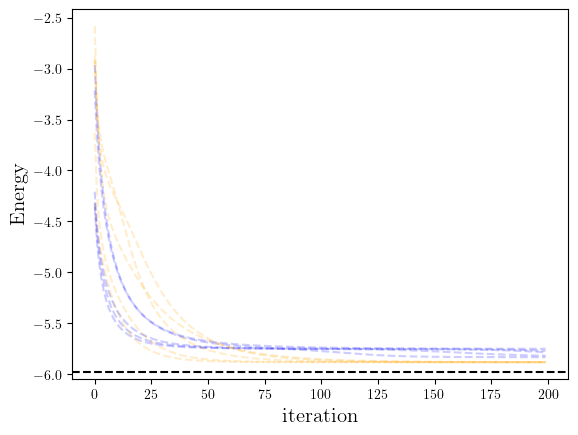

In [21]:
n = 5
for i in range(n):
    plt.plot(ten_result[i], color='blue', linestyle='--', alpha=0.2)
    plt.plot(ten_result2[i], color='orange', linestyle='--', alpha=0.2)
#plt.plot(aver_nm, color='blue')
#plt.plot(aver_nm2, color='orange')

    #plt.plot(ten_result2[i])
plt.xlabel("iteration", fontsize=15)
plt.ylabel("Energy", fontsize=15)

plt.axhline(y=ground_energy, color="black", linestyle="--", label="True energy")

In [22]:
def median(x):
    x = sorted(x)
    length = len(x)
    mid, rem = divmod(length, 2)    # divmod函数返回商和余数
    if rem:
        return x[:mid], x[mid+1:], x[mid]
    else:
        return x[:mid], x[mid:], (x[mid-1]+x[mid])/2
    
x = [1,2,3,4,5,6,7,8]
lHalf, rHalf, q2 = median(x)

x1 = median(lHalf)[2]
x2 = median(rHalf)[2]

In [23]:
data = np.array(ten_result).reshape(n, iteration)
data2 = np.array(ten_result2).reshape(n, iteration)
up1 = []
up2 = []
down1 = []
down2 = []
mean1 = []
mean2 = []
for i in range(iteration):

    nums1 = np.array(data[:,i])
    nums2 = np.array(data2[:,i])
    # x1, x2, m1 = np.percentile(nums1, [25, 75], interpolation='midpoint')
    # y1, y2, m2 = np.percentile(nums2, [25, 75], interpolation='midpoint')
    lHalf, rHalf, q2 = median(nums1)
    lHalf2, rHalf2, q22 = median(nums2)
    
    x1 = median(lHalf)[2]
    x2 = median(rHalf)[2]
    y1 = median(lHalf2)[2]
    y2 = median(rHalf2)[2]
    up1.append(x1)
    down1.append(x2)
    up2.append(y1)
    down2.append(y2)
    mean1.append(q2)
    mean2.append(q22)

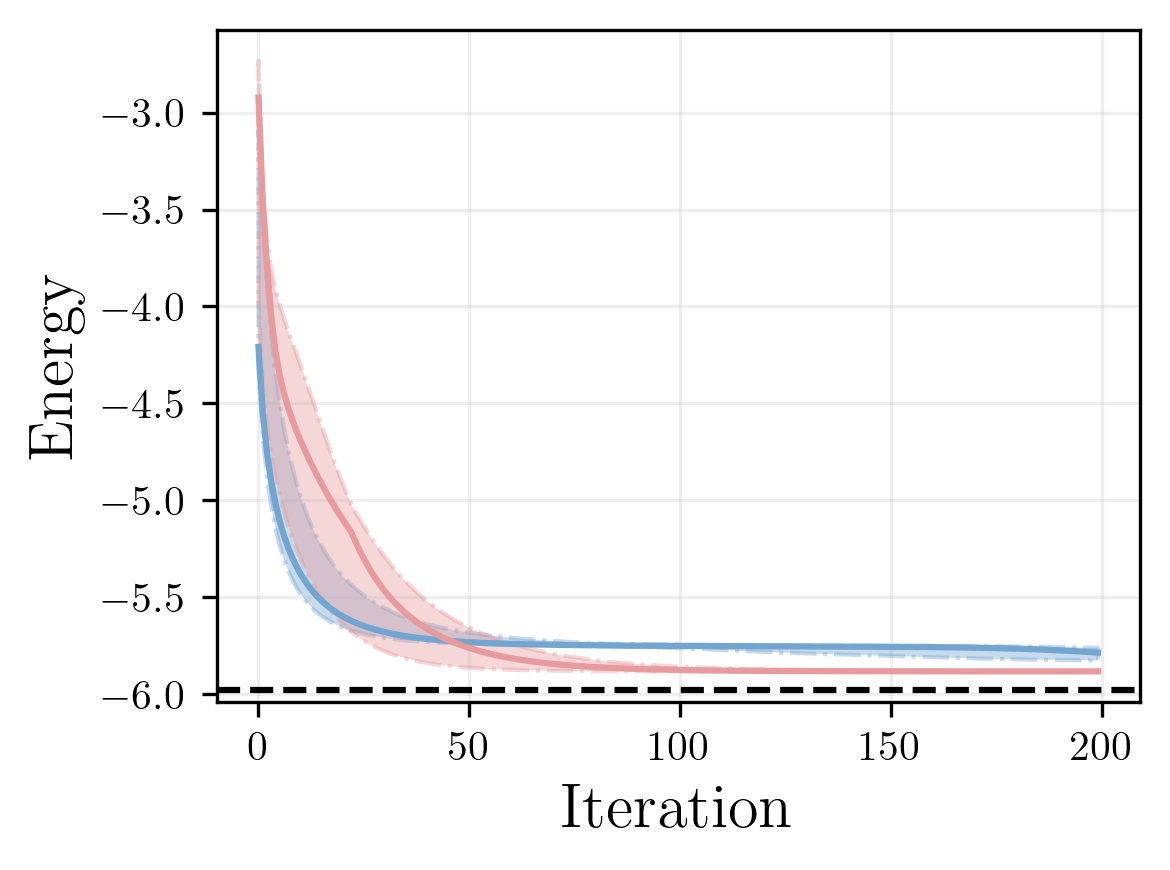

In [24]:
plt.figure(figsize=(4,3), dpi=300)
plt.fill_between(range(iteration), down1, up1, alpha=0.4, edgecolor='#73A5D1', facecolor='#73A5D1',
    linewidth=1, linestyle='dashdot', antialiased=True)
plt.plot(range(iteration),mean1, color='#73A5D1')

plt.fill_between(range(iteration),down2, up2,alpha=0.4, edgecolor='#E89B9E', facecolor='#E89B9E',
    linewidth=1, linestyle='dashdot', antialiased=True)
plt.plot(range(iteration),mean2, color='#E89B9E',linewidth=1.5)
plt.axhline(y=ground_energy, color="black", linestyle="--")
#plt.legend(fontsize=5)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Energy", fontsize=15)
plt.tight_layout()
plt.grid(alpha=0.2)
#plt.savefig("fig9.pdf", format="pdf", bbox_inches="tight")
